In [1]:
import harmonica as hm
import matplotlib.pyplot as plt
import numpy as np
import verde as vd
import xarray as xr
import skimage.exposure
import magali as mg

In [2]:
sensor_sample_distance = 5.0  # µm
region = [0, 2000, 0, 2000]  # µm
spacing = 2  # µm

true_inclination = 30
true_declination = 40
true_dispersion_angle = 5

size = 100

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=5,
)

dipoles_amplitude = abs(np.random.normal(0, 100, size)) * 1.0e-14

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, size), [1250, 1300, 500]]),  # µm
    np.concatenate([np.random.randint(30, 1970, size), [500, 1750, 1000]]),  # µm
    np.concatenate([np.random.randint(-20, -1, size), [-15, -15, -30]]),  # µm
)
dipole_moments = hm.magnetic_angles_to_vec(
    inclination=np.concatenate([directions_inclination, [10, -10, -5]]),
    declination=np.concatenate([directions_declination, [10, 170, 190]]),
    intensity=np.concatenate([dipoles_amplitude, [5e-11, 5e-11, 5e-11]]),
)

data = mg.dipole_bz_grid(
    region, spacing, sensor_sample_distance, dipole_coordinates, dipole_moments
)

data_tga = mg.total_gradient_amplitude_grid(data)
data

/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.DataArray 'bz' (y: 1001, x: 1001)> Size: 8MB
array([[18.19462564, 18.55362094, 18.92271034, ..., 15.52893045,
        15.44573917, 15.35808155],
       [18.38563955, 18.75147789, 19.12771965, ..., 15.92921336,
        15.84279832, 15.75162851],
       [18.57692879, 18.94966924, 19.33312846, ..., 16.34639384,
        16.2565663 , 16.1616729 ],
       ...,
       [ 4.78278372,  4.8320364 ,  4.88218338, ..., 29.68613857,
        29.39345734, 29.08508555],
       [ 4.7485556 ,  4.79731687,  4.84696264, ..., 28.41844579,
        28.14694655, 27.86068127],
       [ 4.71453633,  4.76280735,  4.81195291, ..., 27.21989029,
        26.96782216, 26.701855  ]])
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Attributes:
    long_name:  vertical magnetic field
    units:      nT

In [3]:

stretched = skimage.exposure.rescale_intensity(
    data_tga, 
    in_range=tuple(np.percentile(data_tga, (1, 99))),
)
data_tga_stretched = xr.DataArray(stretched, coords=data_tga.coords)
data_tga_stretched

<xarray.DataArray (y: 1001, x: 1001)> Size: 8MB
array([[0.00520239, 0.002684  , 0.00385305, ..., 0.00322626, 0.00209555,
        0.00474327],
       [0.00074605, 0.00078437, 0.0006854 , ..., 0.00066888, 0.00077362,
        0.00064957],
       [0.00135152, 0.00047313, 0.0008611 , ..., 0.00057067, 0.00019757,
        0.00117587],
       ...,
       [0.00708793, 0.00067754, 0.0019304 , ..., 0.00183136, 0.00080943,
        0.00691159],
       [0.00459907, 0.00190627, 0.00026587, ..., 0.00049514, 0.00173779,
        0.00469612],
       [0.01029255, 0.00171674, 0.00485229, ..., 0.00403247, 0.00094741,
        0.00947642]])
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0

### Stretch the contrast of TGA

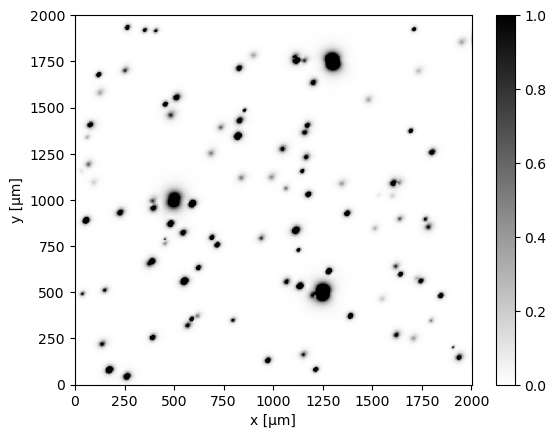

In [4]:
data_tga_stretched.plot.pcolormesh(cmap="gray_r")